# Traffic Sign Recognition Classifier using Tensorflow

This notebook uses as a guide Udacity's template [CarND-Traffic-Sign-Classifier-Project](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb) and also covers all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for that project. An accuracy of 0.93 is the minimum for a successful project submission. 

For this notebook we will train and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained, we will then try out the model on images of German traffic signs found on the web.

[Here](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) is a published baseline model and inspiration for solving the traffic sign problem.

---
## Import Modules
Make sure all the following modules can be imported otherwise you must install them first.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.contrib.layers import flatten
import tensorflow as tf
%matplotlib inline

## Load The Data
The dataset is stored as pickle files and in our case has been placed in a folder called `data`.
Each pickle file contains a dictionary with 4 key/value pairs:

- **features** is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- **labels** is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
- **sizes** is a list containing tuples, (width, height) representing the original width and height the image.
- **coords** is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [3]:
# Fill this in based on where you saved the training, validation, and testing data
training_file = "../data/train.p"
validation_file="../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Visualize and Explore Dataset

There are multiple classes labeled as an id number in this dataset. The file `signnames.csv` contains id to name mappings for each id.


In [5]:
n_train = len(y_train)              # Number of training examples
n_validation = len(y_valid)         # Number of validation examples
n_test = len(y_test)                # Number of testing examples.
n_classes = len(np.unique(y_train)) # Number of classes in data set

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print()
print("Number of classes = ", n_classes)
print("The classes labels are: \n", np.unique(y_train))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples

Number of classes =  43
The classes labels are: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?
Number of examples per label (some have more than others). Do we need to generate fake data?

Sample image in data set with label:
2


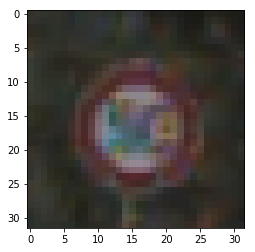

In [7]:
print("Sample image in data set with label:")
idx = random.randint(0, len(X_train))
plt.imshow(X_train[idx])
print(y_train[idx])

---
## Pre-process the Dataset

In [14]:
def preprocess(X, using_type=2):
    """ 
    Preprocess assumes X is of shape [numOfImages, height, width, channels]. 
    Set type number to specify the type of preprocessing you desire:
        Type 1: Quick way to approximately normalize the data (pixel - 128)/ 128.
        Type 2: Classical normalization.
        Type 3: ...
    """
    if (using_type == 1):
        return (X - 128)/ 128
    elif (using_type == 2):
        return (X - np.mean(X))/ np.std(X)
    
Xs_train = preprocess(X_train)
Xs_valid = preprocess(X_valid)
Xs_test = preprocess(X_test)


---
## Model Architecture

Weights and Biases for Net

In [ ]:
# Define layers weight & bias
# wc: convolutional weights  -> [height, width, input_depth, output_depth]
# wd: dropout fc weights     -> [input_depth, output_depth]
# bc, bd: conv and fc biases -> [output_depth]

# Arguments used for tf.truncated_normal
mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 3, 6], mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.random_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.random_normal([5*5*16, 120], mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.random_normal([120, 84], mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.random_normal([84, n_classes], mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.random_normal([6], mean=mu, stddev=sigma)),
    'bc2': tf.Variable(tf.random_normal([16], mean=mu, stddev=sigma)),
    'bd1': tf.Variable(tf.random_normal([120], mean=mu, stddev=sigma)),
    'bd2': tf.Variable(tf.random_normal([84], mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.random_normal([n_classes], mean=mu, stddev=sigma))}

Helper functions for Net

In [ ]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1], # [batch, height, width, depth]
        padding='SAME')
    

Net Classifier

In [ ]:
def LeNet(x, dropout):    
    
    # Layer 1: Convolutional-> Input = 32x32x1. Output = 28x28x6. Activation. Pooling-> Input = 28x28x6. Output = 14x14x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    #print(conv1.get_shape())
    
    # Layer 2: Convolutional-> Output = 10x10x16. Activation. Pooling-> Input = 10x10x16. Output = 5x5x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    #print(conv2.get_shape())

    # Layer 3: Flatten-> Input = 5x5x16 = Output = 400. Fully Connected-> Input = 400. Output = 120. Activation.
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84. Activation.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return out

## Placeholders
`x` is a placeholder for a batch of input images: features.

`y` is a placeholder for a batch of output labels.

`keep_prob` is a placeholder for specifying the probability of nodes to keep when performing dropout in fully connected layers.

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

## Network Parameters

In [ ]:
EPOCHS = 1#10
BATCH_SIZE = 128
dropout = 0.75  # Dropout, probability to keep units in fully connected layers
learning_rate = 0.00001

## Training Pipeline

In [8]:
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation: Training, Validation, and Testing
Evaluate how well the loss and accuracy of the model for a given dataset per batch size. Set `keep_prob`to 1 to use all fc nodes during evaluation.

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={
            x: batch_x,
            y: batch_y,
            keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

---
## Run Session: Train the Model
- Run the training data through the training pipeline to train the model.

- Before each epoch, shuffle the training set.

- After each epoch, measure the loss and accuracy of the validation set.

- Save the model after training.

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.952

Model saved


---

## Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful for labeling the image as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
tf.reset_default_graph()

save_file = 'lenet.ckpt'


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")